# Hilda Beltrán Acosta

### A01251916

### Project 2

### October 1st, 2023

## FIRST PERIOD DATA

In [1]:
# Import libraries to process, manipulate and extract data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Import data from 'dataus2023.csv' file
data = pd.read_csv('dataus2023.csv')

# Import data from 'firmsus2023.csv' file
firms = pd.read_csv('firmsus2023.csv')

## Convert 'q' column to a PeriodIndex

Since our 'q' column has metadata of the period of time between each quarter of the year, we have to convert it to a PeriodIndex object. This will be helpful to create a MultiIndex and be able to access the data easier, this will store information about the time span of each quarter.

In [3]:
# Converting 'q' column into PeriodIndex object, with quarterly frequency
data['qperiod'] = pd.PeriodIndex(data.q, freq='Q')

# Use a MultiIndex with Firm and Quarter period
data.set_index(["firm","qperiod"], inplace=True)

## Merge DataFrames

In [4]:
# Slice DataFrame with columns we're interested in
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]

# Rename this columns as follows
firms1.columns = ['firm', 'Empresa', 'status', 'industria']

# Merge this new DataFrame with the data DataFrame
data = pd.merge(data, firms1, on="firm", how='left')

# 1.1 Calculation of financial variables and ratios

## Calculate log quarterly returns (rq) and log annual returns (ry).

The returns are calculated to evaluate the performance in a certain period of time. We first make an analysis of them quarterly, then annually.

In [5]:
# Calculate log quarterly returns
# We calculate the returns (difference) between the actual and previous data
data['rq'] = np.log(data['adjprice']).diff(1)

# Calculate log annually returns
# We calculate the returns (difference) between the actual and four previous rows data, i.e. q4 - q1
data['ry'] = np.log(data['adjprice']).diff(4)

## Calculate 1-quarter and 4-quarter future log quarterly returns (f1rq and f4rq) and 1-year and 4-year future log quarterly returns (f1ry and f4ry).

In [6]:
# Use the quarterly returns calculated in the next quarter as a prediction for the current f1rq
data['f1rq'] = data.groupby(['firm'])['rq'].shift(-1)
data['f4rq'] = data.groupby(['firm'])['rq'].shift(-4)

data['f1ry'] = data.groupby(['firm'])['ry'].shift(-1)
data['f4ry'] = data.groupby(['firm'])['ry'].shift(-4)

## Calculate operating profit 

### Also called earnings before interest and taxes: ebit = revenue - cogs - sgae

The operating profit of a company is the profitability and efficiency of its primary activities, not taking into account interest and taxes. To calculate this operating profit, we subtract the Cost of Goods Sold and the Operating Expenses, which globally represents how well a company manages its operations in order to end with beneficial profits.

In [7]:
# Calculate the operating profit with the data we already have from the dataset
data['ebit'] = data['revenue'] - data['cogs'] - data['sgae']

## Calculate operating profit margin
### opm = ebit / revenue

The operating profit margin is a metric used to evaluate the earnings before interest and taxes with respect to the total revenues. Meaning it's a ratio between the profitability of a company's primary activities and the total income the company had from this core activities. We can use this metric to evaluate the performance the company is having and understand its financial health.

In [8]:
# Calculate the operating profit margin
# Since it's a ratio, we need to get rid of the zero data in 'revenue', so we replace this
# values with NaN to obtain a division result of NaN
data['opm'] = np.where(data['revenue'] == 0, np.NaN, data['ebit'] / data['revenue'])

## Calculate net income
### netincome = ebit + otherincome + extraordinaryitems - financial expenses - incometax

The net income is the total gain or loss a company had over a specific period of time, this is after deducting all costs from obligations and responsabilites. Giving us an insight on what a comany's performance was, and in a future, it's capability of paying dividends and reinvesting in the company, which is great information for investors.

In [9]:
# Calculate net income
data['netincome'] = data['ebit'] + data['otherincome'] + data['extraordinaryitems'] - data['finexp'] - data['incometax']

## Calculate profit margin
### pm = netincome / revenue

Profit margin is a ratio calculated to obtain information about the company's ability to generate profits after all obligations and responsabilities are met. This margin is also called the net profit margin, since it's calculated with the net income and the revenues. A higher value for the profit margin means there's a higher percentage of the revenues staying as profits for the company.

In [10]:
# Calculate profit margin
# Since it's a ratio, we need to get rid of the zero data in 'revenue', so we replace this
# values with NaN to obtain a division result of NaN
data['pm'] = np.where(data['revenue'] == 0, np.NaN, data['netincome'] / data['revenue'])

## Calculate asset turn over ratio
### ato = revenue / totalassets

The asset turn over ratio represents the ability a company has of generating profits based in its total assets, or in other words, how a company uses its total assets to generate sales that end up as profits. Generally a higher asset turn over ratio means that a company uses their total assets efficiently, even though there's a point in which the value is too high and it can mean there were aggressive behaviours. As an example, this can be interpreted as heavy discounting and not a high performance activity.

In [11]:
# Calculate asset turn over ratio
# Since it's a ratio, we need to get rid of the zero data in 'revenue', so we replace this
# values with NaN to obtain a division result of NaN
data['ato'] = np.where(data['revenue'] == 0, np.NaN, data['revenue'] / data['totalassets'])

## Calculate acid ratio
### acidratio = currentassets / currentliabilities

The acid ratio is known as the ability of fullfilling certain or all obligations and responsabilities with it's current assets, it's a way of measuring whether a company can or can't face short-term financial challenges.

In [12]:
# Calculate acid ratio
# Since it's a ratio, we need to get rid of the zero data in 'currentliabilities', so we replace this
# values with NaN to obtain a division result of NaN
data['acidratio'] = np.where(data['currentliabilities'] == 0, np.NaN, data['currentassets'] / data['currentliabilities'])

## Calculate financial leverage ratio
### finlev=longdebt / totalassets

The financial leverage ratio is a metric used to understand how the operations of a company relies in borrowed finances, meaning the ratio between the debt and the total assets of a company. By having certain debts there's a risk involved, since there's obligations and it's used to evaluate possible outcomes when making important financial decisions. When having a lower value for this ratio, it means that there's a lower reliance in debt and more in the total assets owned by the company.

In [13]:
# Calculate financial leverage ratio
# Since it's a ratio, we need to get rid of the zero data in 'totalassets', so we replace this
# values with NaN to obtain a division result of NaN
data['finlev'] = np.where(data['totalassets'] == 0, np.NaN, data['longdebt'] / data['totalassets'])

## Calculate market value
### mvalue = originalprice * sharesoutstanding

The market value represents an estimation of what a company's worth is at a specific period of time, it's more of what it's believed it's worth. It's calculated by the price people are willing to pay for a share from the company's stock times the total number of shares that are available for trading in the market. This market value will mostly be changing daily, since the price for the shares and the number of shares available can change.

In [14]:
# Calculate market value
data['mvalue'] = data['originalprice'] * data['sharesoutstanding']

## Calculate book value
### bookvalue = totalassets - totalliabilities

The book value represents the net worth of a company, which is calculated by the difference between the total assets owned by the company and the economic obligations it has. It can be seen as the theoretical value of a company, since the market value has a closer focus in the actual point in time and different factors. There's always a difference between this market value and book value, used to understand the financial health of a company, and whether it's performance keeps the company alive or not.

In [15]:
# Calculate book value
data['bookvalue'] = data['totalassets'] - data['totalliabilities']

# 1.2 Firm Composition of the US financial market

Considering the most recent financial quarter of the dataset, which is the second quarter of 2023, since it's the last data we have registered.

## Show how many active firms by industry there are in the sample

In [16]:
# Change display format to show only two decimals
pd.options.display.float_format = '{:,.2f}'.format

# Filter DataFrame where status is activo and the quarter is 2023q2
active_2023q2 = data.loc[(data['status'] == "activo") & (data['q'] == "2023q2")]

# Slice DataFrame to obtain columns of industry and firm
# We group by industry and count the total number of active firms by industry
active_2023q2[['industria', 'firm']].groupby('industria').count()

# Display the information by industry, with the count of firms, descriptive statistics of market value and book value
#This shows the total active firms by industry
industrysummary=active_2023q2.groupby('industria').agg(
{ 'firm':['count'],
 'mvalue':['min','max','median','std'],'bookvalue':['min','max','median','std']}
)
industrysummary

firm       mvalue  \
                                                   count          min   
industria                                                               
-                                                      2 5,231,091.58   
Agricultura, ganadería, aprovechamiento foresta...    17     3,687.58   
Comercio al por mayor                                 79     5,458.41   
Comercio al por menor                                145     3,795.68   
Construcción                                          46     2,212.28   
Empresas de electricidad, gas y agua                  77    33,728.24   
Industrias manufactureras                           1540       796.17   
Información en medios masivos                        256     3,256.72   
Minería, explotación de canteras y extracción d...   113        34.17   
Otros servicios excepto actividades gubernament...    17    16,742.10   
Servicios de alojamiento temporal y de preparac...    71     9,806.64   
Servicios de apoyo a los negocios y manejo de r...   128     2,802.16   
Servicios de esparcimiento culturales y deporti...    24     3,092.33   
Servicios de salud y de asistencia social             63       717.42   
Servicios educativos                                  13    83,986.36   
Servicios financieros y de seguros                   686     5,559.04   
Servicios inmobiliarios y de alquiler de bienes...    68     3,440.61   
Servicios profesionales, científicos y técnicos      137     3,638.32   
Transportes, correos y almacenamiento                 70    29,816.46   

                                                                     \
                                                                max   
industria                                                             
-                                                      5,231,091.58   
Agricultura, ganadería, aprovechamiento foresta...    45,050,089.23   
Comercio al por mayor                                 57,645,136.00   
Comercio al por menor                              1,337,539,706.77   
Construcción                                          41,504,950.92   
Empresas de electricidad, gas y agua                 150,159,578.58   
Industrias manufactureras                          3,050,896,326.94   
Información en medios masivos                      2,532,080,938.79   
Minería, explotación de canteras y extracción d...    69,808,657.11   
Otros servicios excepto actividades gubernament...     9,764,061.13   
Servicios de alojamiento temporal y de preparac...   217,470,301.71   
Servicios de apoyo a los negocios y manejo de r...   444,875,318.55   
Servicios de esparcimiento culturales y deporti...   163,141,789.33   
Servicios de salud y de asistencia social             83,514,600.50   
Servicios educativos                                   3,171,234.18   
Servicios financieros y de seguros                   750,735,436.68   
Servicios inmobiliarios y de alquiler de bienes...   195,201,712.35   
Servicios profesionales, científicos y técnicos    1,519,830,900.00   
Transportes, correos y almacenamiento                153,955,377.34   

                                                                 \
                                                         median   
industria                                                         
-                                                  5,231,091.58   
Agricultura, ganadería, aprovechamiento foresta...   857,921.50   
Comercio al por mayor                              1,450,954.00   
Comercio al por menor                              1,662,158.77   
Construcción                                       2,559,768.80   
Empresas de electricidad, gas y agua               5,192,340.89   
Industrias manufactureras                            684,326.81   
Información en medios masivos                      2,370,194.81   
Minería, explotación de canteras y extracción d... 1,118,078.70   
Otros servicios excepto actividades gubernament... 1,073,749.25   
Servicios d

## For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? 

### 'Agricultura, ganadería, aprovechamiento forestal, pesca y caza'

<Axes: title={'center': 'Market value of Agriculture'}, ylabel='Frequency'>

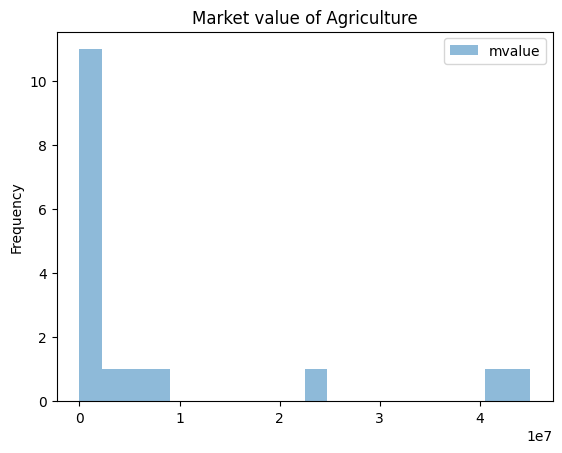

In [18]:
# Filter by industry
mvalue_agricultura = active_2023q2.loc[active_2023q2['industria'] == "Agricultura, ganadería, aprovechamiento forestal, pesca y caza"]

# Get the mvalue attribute
mvalue_agricultura = mvalue_agricultura[['mvalue']]

# Plot a histogram with all the data
mvalue_agricultura.plot.hist(bins = 20, alpha = 0.5, title = "Market value of Agriculture")

<Axes: title={'center': 'Book value of Agriculture'}, ylabel='Frequency'>

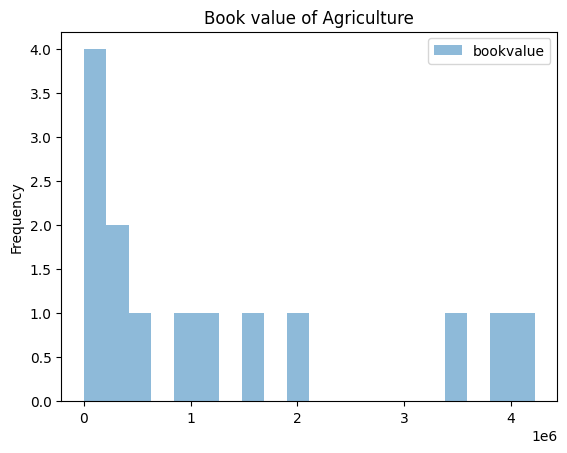

In [19]:
# Filter by industry
bvalue_agricultura = active_2023q2.loc[active_2023q2['industria'] == "Agricultura, ganadería, aprovechamiento forestal, pesca y caza"]

# Get the bookvalue attribute
bvalue_agricultura = bvalue_agricultura[['bookvalue']]

# Plot a histogram with all the data
bvalue_agricultura.plot.hist(bins = 20, alpha = 0.5, title = "Book value of Agriculture")

Since we can observe in the last two histograms, either of our data is uniformly spread like a gaussian bell, meaning we can't trust our mean value to be representative for our data. Something more representative would be the median value, close to where most of the data is located. Which help us reduce the impact extreme data (low and high) can have in the calculus of typical firm size.

For the industry 'Agricultura, ganadería, aprovechamiento forestal, pesca y caza', the typical firm size in terms of market value and book value is of 857,921.50 and 724,592.00. Meaning the typical firm size in terms of market is greater than the typical firm size in terms of book value, representing that the market values the company above the book value.

## How much these variables change within each industry? 

These variables have significant changes within each industry, since not all industries trade the same and there's not the same quantity of firms in each industry sector. But what we can see for most industries is that there's not a normal distribution in the data, as observed in the past histograms.

## How firm size (in market value) is distributed?

<Axes: title={'center': 'Histogram of Market value'}, ylabel='Frequency'>

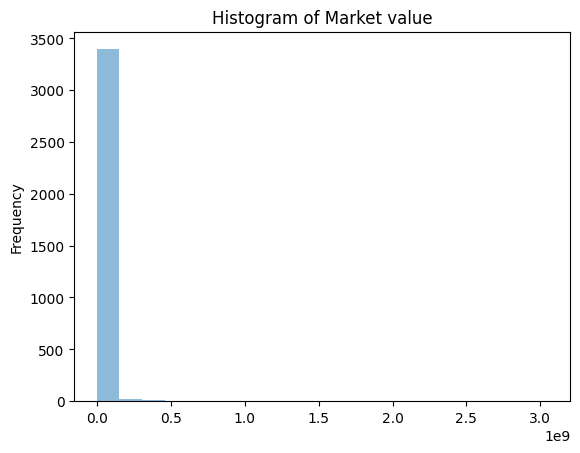

In [20]:
active_2023q2_1 = active_2023q2['mvalue']
active_2023q2_1.plot.hist(bins = 20, alpha = 0.5, title = "Histogram of Market value")

When evaluating the distribution of the firm size in terms of market value, we can observe almost all of our data is located near the value of 1,170,074, and there are some extreme values around 735,452,839 and 3,050,896,326.

## Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?

In [21]:
print('Typical size of a US firm in terms of market value', active_2023q2.mvalue.median())
active_2023q2[['firm', 'mvalue','Empresa','industria']].sort_values(by='mvalue',ascending=False).head(10)

Typical size of a US firm in terms of market value 1170074.0124050002


,firm,mvalue,Empresa,industria
1138,AAPL,"3,050,896,326.94",Apple Inc,Industrias manufactureras
316182,MSFT,"2,532,080,938.79",Microsoft Corp,Información en medios masivos
207232,GOOGL,"1,519,830,900.00",Alphabet Inc,"Servicios profesionales, científicos y técnicos"
28396,AMZN,"1,337,539,706.77","Amazon.Com, Inc",Comercio al por menor
338687,NVDA,"1,044,859,400.00",Nvidia Corp,Industrias manufactureras
478367,TSLA,"829,681,140.87","Tesla, Inc",Industrias manufactureras
72866,BRK_A,"750,735,436.68",Berkshire Hathaway Inc,Servicios financieros y de seguros
301173,META,"735,452,839.12","Meta Platforms, Inc","Servicios profesionales, científicos y técnicos"
489577,UNH,"447,491,234.90",Unitedhealth Group Inc,Servicios financieros y de seguros
280653,LLY,"445,190,020.12",Eli Lilly And Company,Industrias manufactureras


The 10 biggest US firms in terms of market value are quite far from the typical size of a US firm, since most of the sizes are considered small, the median value, which represents the typical size, is really far. This is due to extreme values, in this case the biggest US firms, being present which creates a standard deviation quite big. Explaining this distances between the biggest firms and the typical size.

## Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?

In [22]:
print('Typical size of a US firm in terms of book value', active_2023q2.bookvalue.median())
active_2023q2[['firm', 'bookvalue','Empresa','industria']].sort_values(by='bookvalue',ascending=False).head(10)

Typical size of a US firm in terms of book value 500654.5


,firm,bookvalue,Empresa,industria
72866,BRK_A,"539,883,000.00",Berkshire Hathaway Inc,Servicios financieros y de seguros
259753,JPM,"312,516,000.00",Jpmorgan Chase & Co,Servicios financieros y de seguros
53286,BAC,"283,319,000.00",Bank Of America Corp,Servicios financieros y de seguros
207232,GOOGL,"267,141,000.00",Alphabet Inc,"Servicios profesionales, científicos y técnicos"
79421,C,"209,422,000.00",Citigroup Inc,Servicios financieros y de seguros
525961,XOM,"206,997,000.00",Exxon Mobil Corp,Industrias manufactureras
316182,MSFT,"206,223,000.00",Microsoft Corp,Información en medios masivos
513136,WFC,"181,952,000.00",Wells Fargo & Company,Servicios financieros y de seguros
28396,AMZN,"168,602,000.00","Amazon.Com, Inc",Comercio al por menor
127623,CVX,"159,298,000.00",Chevron Corp,Industrias manufactureras


The 10 biggest US firms in terms of book value are quite far from the typical size of a US firm, since most of the sizes are considered small, the median value, which represents the typical size, is really far. This is due to extreme values, in this case the biggest US firms, being present which creates a standard deviation quite big. Explaining this distances between the biggest firms and the typical size.

Since the book value is a theoretical value of a company, there's not the same companies in the 10 biggest US firms according to their market value than the ones present in the 10 biggest US firms according to the book value. 

# 1.3 Evolution of the US financial market

Considering the whole history of financial data for all firms, and only annual fiscal information (selecting fiscalmonth=12)

## How the total market value of the US market has changed over the years? Do a table and/or graph and explain

In [23]:
# Filter the data DataFrame to find the last fiscal month of the year
datay=data.loc[data['fiscalmonth']==12]

# Group the market value by year and sum this values
mvaly = datay[['mvalue', 'year']].groupby('year').sum()
mvaly

,mvalue
year,
2000,"12,814,978,634.15"
2001,"11,494,392,671.37"
2002,"9,494,723,157.61"
2003,"11,675,951,523.21"
2004,"13,230,878,635.88"
2005,"13,789,108,526.52"
2006,"15,461,254,772.55"
2007,"16,149,130,338.06"
2008,"10,395,016,561.41"


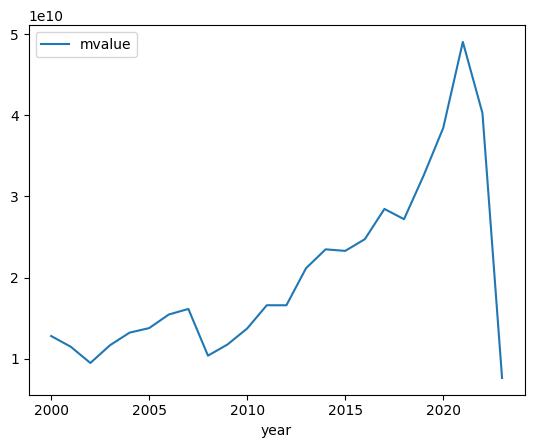

In [24]:
# Graph the information stored in the last table
mvaly = datay[['year','mvalue']].groupby('year').sum().plot(legend=True)

Taking a look into the graph, there's a noticeable growth between the market value in 2000 and in 2022, which is the last 12th fiscal month, this growth is of about 4 or 5 times bigger. We can't take into consideration the year 2023 since it's not complete yet, and the evaluation considers the market value among the year, so the last complete year is 2022.

Analyzing its beahaviour we can see the trend for the market value is to grow, almost always, which can give us insights on potential investment opportunities. We can notice there's not extreme changes between one year and another, meaning the market value exponentially increments and then decrements, meaning it's volatility is low and this can represent lower risks when investing. Even though there's a lower risk, this lower fluctuations may also represent less opportunities for investors.

This graph can also show us special events that happened in this historical values, we can notice a decline in the market value around the year 2020, in which the COVID-19 pandemic had its greatest impact.

## How total revenue and total net income of all US firms has changed over the years? Do a table and/or graph and explain

In [25]:
# Group the market value by year and sum this values
r_ni_y = datay[['revenue', 'netincome', 'year']].groupby('year').sum()
r_ni_y

,revenue,netincome
year,,
2000,"6,650,301,475.86","344,723,426.83"
2001,"7,757,319,661.87","67,530,325.20"
2002,"7,575,463,606.79","-57,773,458.77"
2003,"8,213,607,184.22","364,552,095.88"
2004,"9,111,916,600.06","431,717,996.76"
2005,"9,975,745,857.16","522,880,104.83"
2006,"10,941,769,398.44","657,926,147.83"
2007,"11,603,740,650.63","610,497,891.61"
2008,"11,769,845,526.77","342,187,423.38"


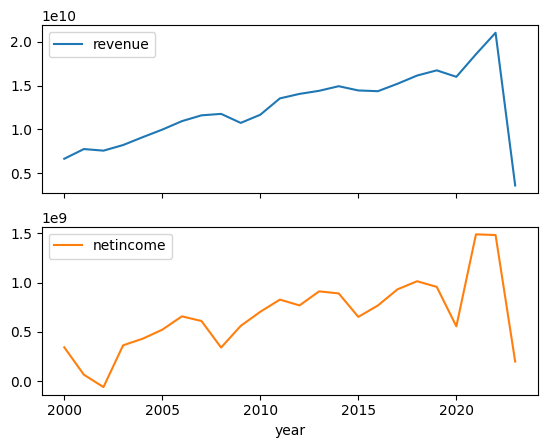

In [26]:
# Graph the information stored in the last table
r_ni_y = datay[['year','revenue', 'netincome']].groupby('year').sum().plot(subplots = True, legend=True)

Analyzing the graph, we can notice an upward trend in the total revenues, having a growth of 2 times more than the revenues the US firms had in the year 2000. We can't take into consideration the year 2023 since it's not complete yet, and the evaluation considers the market value among the year, so the last complete year is 2022.

The observed growing trend gives us information about how risky or interesting it would be to invest, in this case, the risk is somehow low since the fluctuations are not big, ensuring a safer investment. The revenues graph can tell us whether a company is having trouble with its sales or, on the other hand, growing its sales in certain period of time.

The net income graph along the years gives us information about the behaviour of the total earnings of the company after subtracting the economical obligations and responsabilities. We can observe there is some volatility in the data between periods of tiem, meaning there are up and downs. We can interpret from this variations that there are some periods in which there's an improved profitability and there's some where the financial performance of the company is really low.

We can see there's a net growth of 3 times the net income from 2000 to the year 2022, since it's the last complete financial year.

## 1.4 Learing about one industry

Service Industries

# 1.4.1 Descriptive statistics for your industry

### Using the subsample of your industry and using annual fiscal information (selecting rows with fiscalmonth=12), and the most recent complete year (2022), do the following

### Show descriptive statistics for future quarterly log return, annual return, total assets, revenue, netincome and all financial ratios calculated above. Provide a clear interpretation of the descriptive statistics of revenue and 1 financial ratio

In [27]:
# Filter data by industry, annual fiscal information at the most recent complete year and with an active status
services_2022 = data.loc[(data.industria.str.contains('Servicios')) & (data.fiscalmonth == 12) & (data.year == 2022) & (data.status == 'activo')].copy()

# Drop 'Servicios financieros y de seguros' from our industry selection, since it's a separate industry
services_2022.drop(services_2022.loc[services_2022.industria == 'Servicios financieros y de seguros'].index, inplace = True)

# Select variables and ratios from the data frame and get a descriptive statistics analysis from it
services_2022 = services_2022[['firm', 'q', 'revenue', 'netincome', 'totalassets', 'mvalue', 'bookvalue', 'opm', 'pm', 'ato', 'finlev', 'acidratio', 'rq', 'f1rq', 'currentassets', 'currentliabilities', 'longdebt']]
services_2022.describe()

,revenue,netincome,totalassets,mvalue,bookvalue,opm,pm,ato,finlev,acidratio,rq,f1rq,currentassets,currentliabilities,longdebt
count,485.00,480.00,485.00,481.00,485.00,475.00,475.00,480.00,463.00,457.00,479.00,481.00,485.00,458.00,463.00
mean,"3,931,102.61","314,946.55","6,663,127.22","10,962,585.65","2,357,628.02",-2.41,-3.03,0.88,0.33,3.26,-0.03,0.03,"1,977,956.48","1,515,138.33","2,301,313.71"
std,"15,280,229.54","3,303,838.26","22,903,181.50","60,311,972.18","14,114,573.13",25.13,37.17,1.57,0.29,11.05,0.30,0.27,"8,858,650.24","4,983,643.36","5,457,218.55"
min,0.00,"-16,720,000.00","2,704.28","3,455.37","-8,876,000.00",-459.92,-755.42,0.00,0.00,0.09,-1.85,-1.37,880.67,0.00,0.00
25%,"244,954.00","-25,052.85","391,041.00","250,390.80","60,118.00",-0.08,-0.11,0.37,0.07,1.01,-0.16,-0.09,"97,717.40","62,911.25","22,118.00"
50%,"821,354.00","12,558.50","1,533,100.00","1,277,904.45","399,150.00",0.05,0.03,0.63,0.29,1.50,0.03,0.04,"348,619.00","264,715.50","403,927.00"
75%,"2,825,379.00","177,727.50","5,334,100.00","4,820,800.60","1,505,067.00",0.14,0.09,1.05,0.48,2.53,0.15,0.17,"1,211,817.00","896,528.75","2,018,611.50"
max,"282,836,000.00","59,972,000.00","365,264,000.00","1,141,960,890.00","256,144,000.00",0.81,9.94,29.46,1.96,208.29,0.88,1.21,"164,795,000.00","69,300,000.00","48,037,900.00"


#### REVENUE

The descriptive satistics of Revenue tells us how the data is distributed along the years; we're talking about 485 registers of different Services Industry firms. Since there are really disperse data, the standard deviation value is really high and the mean is not a value we can take into consideration when talking about the typical revenue of a firm in a period of time. We can simply observe the great difference between the maximum and minimum values, there are even firms with 0.00 as revenue for that period of time. 

#### ACID RATIO

The descriptive statistics of the Acid Ratio tells us whether a company has the ability to fulfill its economical obligations relying on the assets owned at the moment. Noticing the mean with its standard deviation, we can see there's not a normal distribution, meaning we have outliers from our data than can be causing this weird values. Since we're talking about the ability of covering their taxes, debts, with their assets, we can see that the extreme values in this ratio are due to the extremely wealthy firms. So we report the median value, in which 50% of the data falls, when analyzing this value we can observe that a typical acid ratio for the services industry is around 1.50, which means the firms are able to fulfill this obligations with their current assets. This can be seen when the acid ratio is greater than 1.0, on the contrary, if the acid ratio is less than 1.0, there's a high probability the firm won't be able to cover this obligations with their assets, and may need to use other resources.

## SECOND PERIOD DATA

### For the ratios, instead of calculating the arithmetic mean of the ratios, calculate the weighted average of the ratios. To calculate the weighted average of a ratio, you have to divide the sum of the numerator variable by the sum of the denominator variable. For example, to calculate the weighted average of profit margin you first sum all the net income of all firms and then divide it by the sum of revenue of all firms.

### Compare this weighted average with the arithmetic mean and the median. Which is the best measure for central tendency of the ratios? Interpret the weighted average of profit margin and asset turn over of your industry.

In [28]:
# Calculate weighted average of profit margin ratio
weighted_pm = services_2022['netincome'].sum() / services_2022['revenue'].sum()

# Print weighted average, mean and median for profit margin ratio
print('Profit Margin')
print('Weighted Average:', weighted_pm)
print('Mean:', services_2022['pm'].mean())
print('Median:', services_2022['pm'].median())

Profit Margin
Weighted Average: 0.07929064984060817
Mean: -3.0328398306155147
Median: 0.029095590601866752


The calculated weighted average of the profit margin shows there's a 7.9% of the revenues that stay as profits for the industry; since the profit margin is the profit after obligations and responsabilities. When comparing this value with the mean and median for the profit margin, we notice the value of the mean is quite different, meaning it's not significantly correct. Since the data has not a normal distribution, and the median is close to the weighted average, but it's still different.

In [29]:
# Calculate weighted average of asset turn over ratio
weighted_ato = services_2022['revenue'].sum() / services_2022['totalassets'].sum()

# Print weighted average, mean and median for asset turn over ratio
print('Asset Turn Over')
print('Weighted Average:', weighted_ato)
print('Mean:', services_2022['ato'].mean())
print('Median:', services_2022['ato'].median())

Asset Turn Over
Weighted Average: 0.5899786208581964
Mean: 0.8833978437660064
Median: 0.6289319962409221


The weighted average of the asset turn over ratio tells us that 58.99% of the total assets of the industry are being used efficiently, since they generate sales that end up being profits for the industry. When comparing the value of the mean and median, we observe they're not really different, even though the median is closer to the weighted average. Meaning the best metric is the median for this ratio.

In [30]:
# Calculate weighted average of acid ratio
weighted_acidratio = services_2022['currentassets'].sum() / services_2022['currentliabilities'].sum()

# Print weighted average, mean and median for acid ratio
print('Acid Ratio')
print('Weighted Average:', weighted_acidratio)
print('Mean:', services_2022['acidratio'].mean())
print('Median:', services_2022['acidratio'].median())

Acid Ratio
Weighted Average: 1.3824222309937733
Mean: 3.260211217537816
Median: 1.5023550430404418


The weighted average of the acid ratio tells us 138% of the times, the obligations and responsabilites of the industry are being fullfilled with the current assets of the industry. Since the mean is way more far than the value for the median, the median is a better way of measuring the central tendency of the acid ratio.

In [31]:
# Calculate weighted average of financial leverage ratio
weighted_finlev = services_2022['longdebt'].sum() / services_2022['totalassets'].sum()

# Print weighted average, mean and median for financial leverage ratio
print('Financial Leverage')
print('Weighted Average:', weighted_finlev)
print('Mean:', services_2022['finlev'].mean())
print('Median:', services_2022['finlev'].median())

Financial Leverage
Weighted Average: 0.3297136840826774
Mean: 0.3281020024764021
Median: 0.28819103087701653


The weighted average of the financial leverage ratio tells us that 32.9%, which is not a really high value, meaning the industry doesn't rely mostly on it's debt but in their total assets. Since the mean has a closest value to the weighted average, it can be considered the best metric for the central tendency of the financial leverage ratio. Even though the median is not that far, and can also be used to describe this.

### For the complete historical dataset of annual fiscal years (fiscalmonth=12 for all quarter-years), you have to calculate the following new independent variables:

In [32]:
# Ignore warnings about encountered divisions by 0
np.seterr(divide = 'ignore') 

# Filter data set by industry, annual fiscal data and an active status
services = data.loc[(data.industria.str.contains('Servicios')) & (data.fiscalmonth == 12) & (data.status == 'activo')].copy()

# Drop 'Servicios financieros y de seguros' from our industry selection, since it's a separate industry
services.drop(services.loc[services.industria == 'Servicios financieros y de seguros'].index, inplace = True)

# Select variables and ratios from the data frame
#services = services[['firm', 'q', 'revenue', 'netincome', 'totalassets', 'mvalue', 'bookvalue', 'opm', 'pm', 'ato', 'finlev', 'acidratio', 'rq', 'ry', 'f1rq', 'sharesoutstanding', 'ebit', 'originalprice']]

# Use the logarithm transformation to the variables which are not ratios and merge them to the dataframe
services['logta'] = np.where(services['totalassets'] == 0, np.NaN, np.log(services['totalassets']))
services['logrev'] = np.where(services['revenue'] == 0, np.NaN, np.log(services['revenue']))
services['logni'] = np.where(services['netincome'] == 0, np.NaN, np.log(services['netincome']))
services

C:\Users\hilda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,netincome,pm,ato,acidratio,finlev,mvalue,bookvalue,logta,logrev,logni
2514,ABM,2011q4,12.00,"4,246,842.00","3,781,264.00","348,010.00",0.00,"3,721.00","15,805.00","36,980.00",...,"68,504.00",0.02,2.26,1.66,0.16,"1,100,149.40","795,886.00",14.45,15.26,11.13
2518,ABM,2012q4,12.00,"4,300,265.00","3,854,380.00","349,319.00",-313.00,"6,259.00","9,999.00","29,931.00",...,"62,582.00",0.01,2.30,1.62,0.12,"1,085,532.03","850,398.00",14.44,15.27,11.04
2522,ABM,2013q4,12.00,"4,809,281.00","4,313,429.00","376,827.00",0.00,"6,319.00","12,892.00","39,552.00",...,"72,900.00",0.02,2.27,1.70,0.15,"1,587,411.60","917,507.00",14.57,15.39,11.20
2526,ABM,2014q4,12.00,"5,032,800.00","4,513,500.00","390,700.00",0.00,"6,500.00","10,700.00","48,800.00",...,"75,600.00",0.02,2.30,1.76,0.15,"1,597,236.55","968,800.00",14.60,15.43,11.23
2530,ABM,2015q4,12.00,"4,897,800.00","4,410,000.00","414,200.00",0.00,"31,200.00","10,200.00","18,300.00",...,"76,300.00",0.02,2.28,1.67,0.07,"1,596,367.05","1,007,500.00",14.58,15.40,11.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532117,ZS,2018q3,12.00,"190,174.00","37,875.00","186,923.00",79.00,0.00,"-2,236.00","1,337.00",...,"-33,646.00",-0.18,0.42,2.12,0.00,"4,884,348.32","240,236.00",13.01,12.16,NaN
532121,ZS,2019q3,12.00,"302,836.00","59,669.00","278,480.00",-329.00,0.00,"-7,730.00",743.00,...,"-28,655.00",-0.09,0.50,1.89,0.00,"6,023,519.80","308,558.00",13.31,12.62,NaN
532125,ZS,2020q3,12.00,"431,269.00","95,733.00","449,492.00",-224.00,0.00,"-1,452.00","2,388.00",...,"-115,116.00",-0.27,0.24,3.73,0.49,"18,698,591.43","484,829.00",14.42,12.97,NaN
532129,ZS,2021q3,12.00,"673,100.00","150,317.00","730,595.00","1,186.00",0.00,"50,552.00","4,851.00",...,"-262,029.00",-0.39,0.30,2.57,0.42,"36,379,348.94","528,895.00",14.63,13.42,NaN


### Firm size as a categorical variable. For each quarter, you have to label firms in 3 equal groups: small, medium, big according to the market value of the firms.

The DataFrame is sorted by the Market Value, in order to split the DataFrame into three equal groups, tagged by small, medium and big. We'll drop the NaN values and reset the index to get a new DataFrame without Null data.

In [33]:
# Sort by mvalue and drop NaN values
services = services.sort_values(by = 'mvalue')
services.dropna(subset=['mvalue'], inplace = True)
services = services.reset_index(drop = True)

In [34]:
labels = ['S', 'M', 'B']
b = np.ceil(services.shape[0] / 3)
bins = [0, b, b * 2, float('inf')]
services['size'] = pd.cut(services.index, bins=bins, labels=labels, include_lowest=True)
services

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,pm,ato,acidratio,finlev,mvalue,bookvalue,logta,logrev,logni,size
0,IZEA,2012q4,12.00,"4,954.24","2,150.38","7,269.32",-91.38,0.00,115.80,0.00,...,-0.94,3.53,0.49,0.08,"1,125.14","-1,313.45",7.25,8.51,NaN,S
1,WORX,2018q4,12.00,150.09,0.00,"3,733.39",54.60,"-10,804.75",258.80,0.00,...,-97.22,0.03,0.66,0.00,"2,832.42","-2,907.69",8.64,5.01,NaN,S
2,SQL,2022q4,12.00,78.66,0.69,"4,075.12",-51.82,0.00,45.87,0.00,...,-52.06,0.01,5.40,0.34,"3,455.37","4,366.89",9.04,4.37,NaN,S
3,INPX,2017q4,12.00,"45,134.00","34,312.00","40,307.00","-1,689.00",-18.00,"3,821.00",0.00,...,-0.78,1.63,0.22,0.03,"3,482.56","-18,853.00",10.23,10.72,NaN,S
4,GTIM,2012q3,12.00,"19,706.00","10,531.00","9,649.00",5.00,-109.00,199.00,0.00,...,-0.04,2.79,1.28,0.02,"3,489.55","3,260.00",8.86,9.89,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5174,META,2021q4,12.00,"117,929,000.00","22,649,000.00","48,527,000.00","531,000.00",0.00,0.00,"7,914,000.00",...,0.33,0.71,3.15,0.08,"935,644,813.21","124,879,000.00",18.93,18.59,17.49,B
5175,GOOGL,2022q4,12.00,"282,836,000.00","126,203,000.00","81,791,000.00","-3,514,000.00",0.00,0.00,"11,356,000.00",...,0.21,0.77,2.38,0.07,"1,141,960,890.00","256,144,000.00",19.72,19.46,17.91,B
5176,GOOGL,2020q4,12.00,"182,527,000.00","84,732,000.00","56,571,000.00","6,858,000.00",0.00,0.00,"7,813,000.00",...,0.22,0.57,3.07,0.08,"1,185,531,741.36","222,544,000.00",19.58,19.02,17.51,B
5177,GOOGL,2021q4,12.00,"257,637,000.00","110,939,000.00","67,984,000.00","12,020,000.00",0.00,0.00,"14,701,000.00",...,0.30,0.72,2.93,0.07,"1,922,950,841.18","251,635,000.00",19.70,19.37,18.15,B


### Calculate the corresponding dummy (binary) variables for the firm size following the dummy encoding method.

We'll calculate dummies for the categorical feature of firm size, in order to have corresponding data to run the multiple regression model. We'll get a column for medium and big, and assume if it's not any of these categories, then it's a small firm.

In [35]:
services = pd.get_dummies(services, columns = ['size'], prefix = 'dmy', dtype = 'int', drop_first = True)
services

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,ato,acidratio,finlev,mvalue,bookvalue,logta,logrev,logni,dmy_M,dmy_B
0,IZEA,2012q4,12.00,"4,954.24","2,150.38","7,269.32",-91.38,0.00,115.80,0.00,...,3.53,0.49,0.08,"1,125.14","-1,313.45",7.25,8.51,NaN,0,0
1,WORX,2018q4,12.00,150.09,0.00,"3,733.39",54.60,"-10,804.75",258.80,0.00,...,0.03,0.66,0.00,"2,832.42","-2,907.69",8.64,5.01,NaN,0,0
2,SQL,2022q4,12.00,78.66,0.69,"4,075.12",-51.82,0.00,45.87,0.00,...,0.01,5.40,0.34,"3,455.37","4,366.89",9.04,4.37,NaN,0,0
3,INPX,2017q4,12.00,"45,134.00","34,312.00","40,307.00","-1,689.00",-18.00,"3,821.00",0.00,...,1.63,0.22,0.03,"3,482.56","-18,853.00",10.23,10.72,NaN,0,0
4,GTIM,2012q3,12.00,"19,706.00","10,531.00","9,649.00",5.00,-109.00,199.00,0.00,...,2.79,1.28,0.02,"3,489.55","3,260.00",8.86,9.89,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5174,META,2021q4,12.00,"117,929,000.00","22,649,000.00","48,527,000.00","531,000.00",0.00,0.00,"7,914,000.00",...,0.71,3.15,0.08,"935,644,813.21","124,879,000.00",18.93,18.59,17.49,0,1
5175,GOOGL,2022q4,12.00,"282,836,000.00","126,203,000.00","81,791,000.00","-3,514,000.00",0.00,0.00,"11,356,000.00",...,0.77,2.38,0.07,"1,141,960,890.00","256,144,000.00",19.72,19.46,17.91,0,1
5176,GOOGL,2020q4,12.00,"182,527,000.00","84,732,000.00","56,571,000.00","6,858,000.00",0.00,0.00,"7,813,000.00",...,0.57,3.07,0.08,"1,185,531,741.36","222,544,000.00",19.58,19.02,17.51,0,1
5177,GOOGL,2021q4,12.00,"257,637,000.00","110,939,000.00","67,984,000.00","12,020,000.00",0.00,0.00,"14,701,000.00",...,0.72,2.93,0.07,"1,922,950,841.18","251,635,000.00",19.70,19.37,18.15,0,1


### Calculate operating earnings per share deflated by stock price: oepsp = (ebit / sharesoutstanding) / originalprice

In [36]:
services['oepsp'] = np.where(services['sharesoutstanding'] == 0, np.NaN, (services['ebit'] / services['sharesoutstanding']) / services['originalprice'])

### Calculate earnings per share deflated by stock price: epsp = (netincome / sharesoutstanding) / originalprice

In [37]:
services['epsp'] = np.where(services['sharesoutstanding'] == 0, np.NaN, (services['netincome'] / services['sharesoutstanding']) / services['originalprice'])

### Calculate book-to-market ratio: bmr = bookvalue / marketvalue

In [38]:
services['bmr'] = services['bookvalue'] / services['mvalue']

## In this model, the variable you have to use as dependent variable will be annual stock returns (instead of quarterly returns) one quarter in the future (f1.ry).

# Winsorization of variables

### Original Ratios

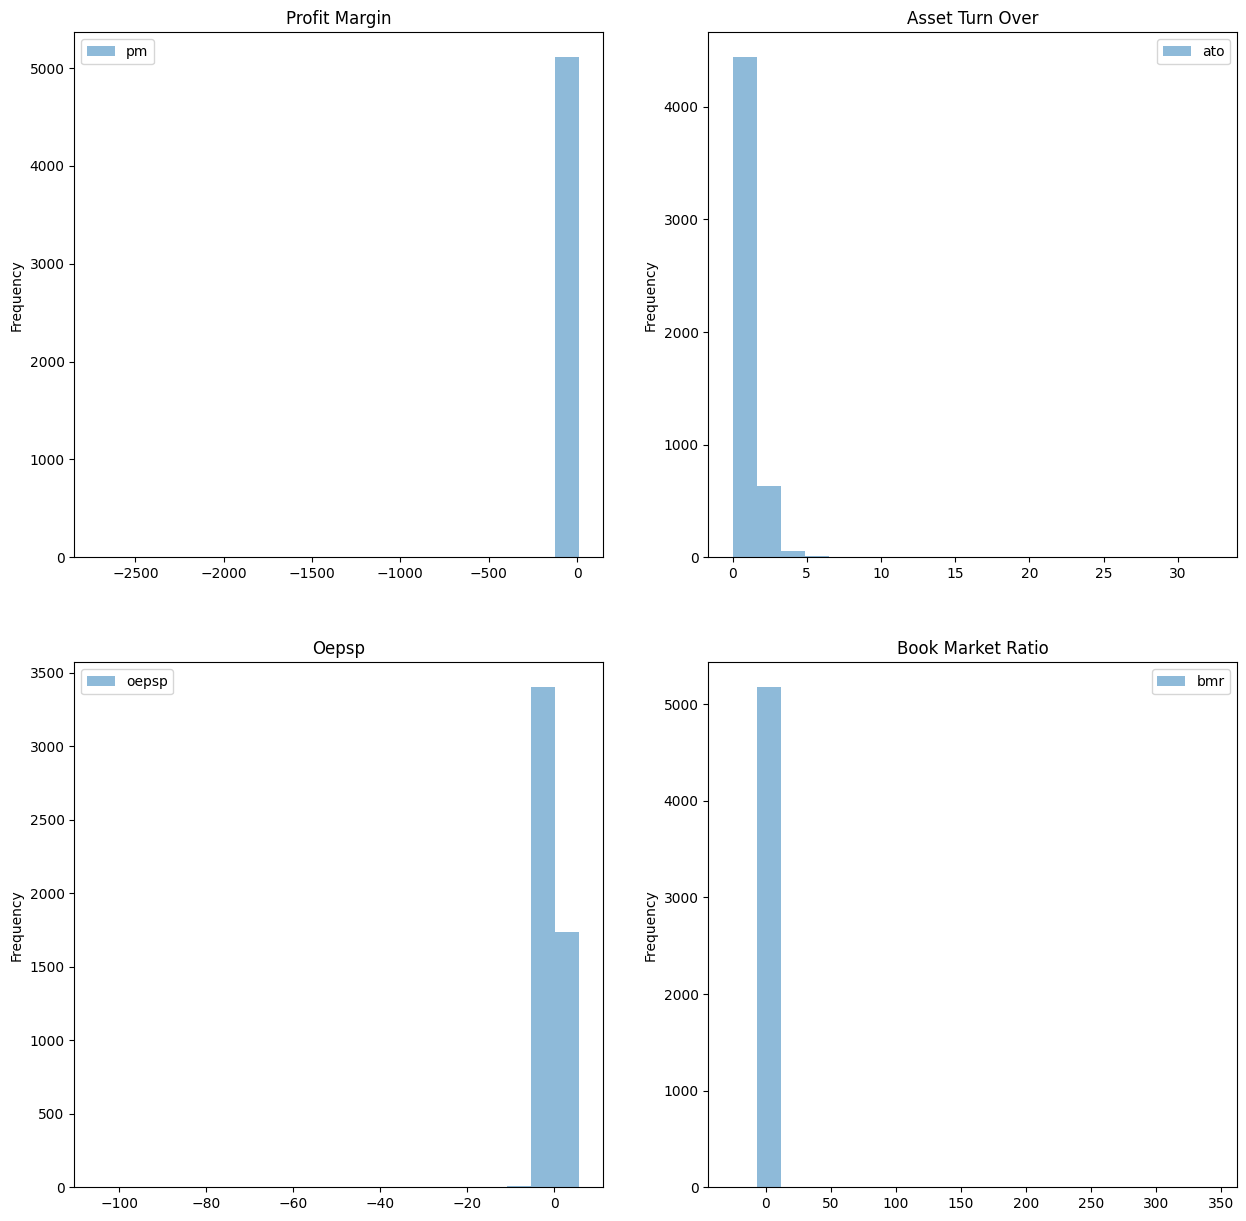

In [39]:
plt.figure(figsize = (15,15))

plt.subplot(2,2,1)
pm = services[['pm']]
pm.plot.hist(bins = 20, alpha = 0.5, title = "Profit Margin", ax=plt.gca())

plt.subplot(2,2,2)
ato = services[['ato']]
ato.plot.hist(bins = 20, alpha = 0.5, title = "Asset Turn Over", ax=plt.gca())

plt.subplot(2,2,3)
oepsp = services[['oepsp']]
oepsp.plot.hist(bins = 20, alpha = 0.5, title = "Oepsp", ax = plt.gca())

plt.subplot(2,2,4)
bmr = services[['bmr']]
bmr.plot.hist(bins = 20, alpha = 0.5, title = "Book Market Ratio", ax = plt.gca())

plt.show()

We can see there are many extreme values in all of the ratios we're evaluating, meaning we don't have normal distributions in either of these variables. In this case, to obtain a more stable data to analyze, we'll apply winsorization to all of our ratios that present extreme values. This will help us reduce the impact these extreme values have.

### Apply Winsorization

Since the distribution of the data in our ratios is not normal, we apply winsorization, even though we want to reduce this impact, we need to preserve at least 98% of our original data. Therefore, the winsorization limits are no higher than 1% for each operation.

In [40]:
services['w_pm'] = winsorize(services['pm'], (0.01, 0.01))
services['w_ato'] = winsorize(services['ato'], (0.0, 0.01))
services['w_oepsp'] = winsorize(services['oepsp'], (0.01, 0.01))
services['w_bmr'] = winsorize(services['bmr'], (0.01, 0.01))
services['w_epsp'] = winsorize(services['epsp'], (0.01, 0.01))

### Winsorized Ratios

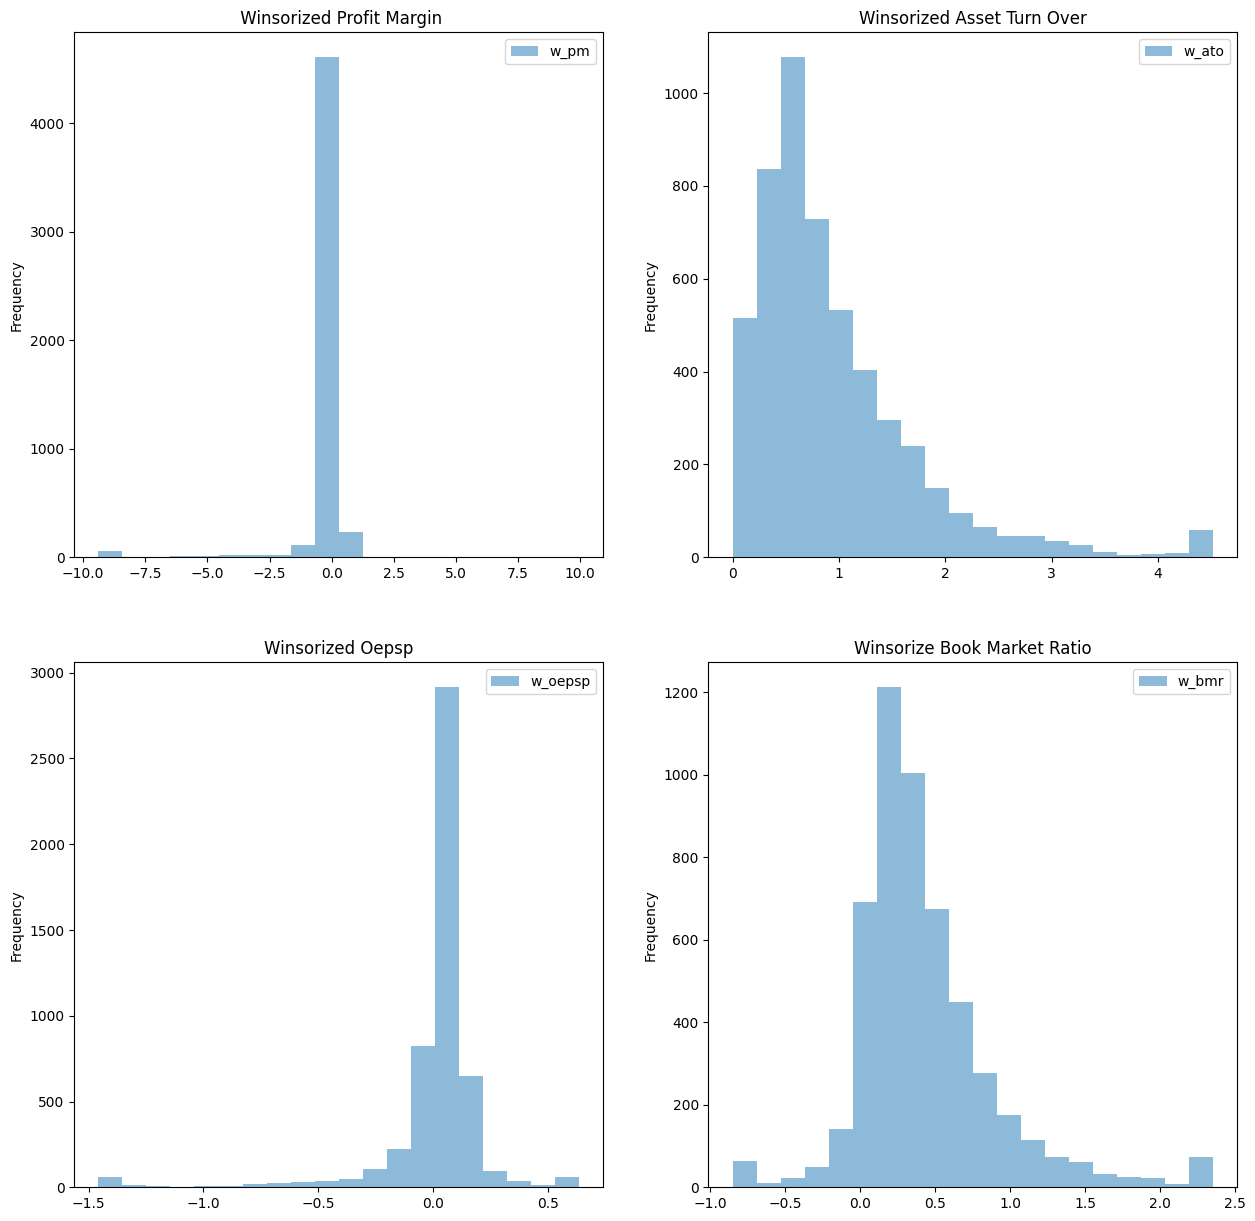

In [41]:
plt.figure(figsize = (15,15))

plt.subplot(2,2,1)
w_pm = services[['w_pm']]
w_pm.plot.hist(bins = 20, alpha = 0.5, title = " Winsorized Profit Margin", ax=plt.gca())

plt.subplot(2,2,2)
w_ato = services[['w_ato']]
w_ato.plot.hist(bins = 20, alpha = 0.5, title = "Winsorized Asset Turn Over", ax=plt.gca())

plt.subplot(2,2,3)
w_oepsp = services[['w_oepsp']]
w_oepsp.plot.hist(bins = 20, alpha = 0.5, title = "Winsorized Oepsp", ax = plt.gca())

plt.subplot(2,2,4)
w_bmr = services[['w_bmr']]
w_bmr.plot.hist(bins = 20, alpha = 0.5, title = "Winsorize Book Market Ratio", ax = plt.gca())

plt.show()

Even though it's not perfect, we can see a more normal distribution in each of our ratios, once we test it in our new models, we hope to see a more stable regression model with a higher R2.

# Multicollienarity

Multicollinearity happens when we have more than one independent variable, and they have a high correlation between them. In this case, I used the VIF technique to detect multicollinearity.

In [42]:
# Create a data frame with the columns of the services
features = pd.DataFrame()
X1 = services[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr']]
X1 = X1.dropna()
features["feature"] = X1.columns

# Add a column for the variance inflation factor
features['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
features

,feature,VIF
0,w_pm,1.24
1,w_ato,1.42
2,w_epsp,4.22
3,w_oepsp,4.09
4,w_bmr,1.39


Analyzing the results we see the winsorized ratio of epsp has the higher value for multicollinearity, and it's not high. So, we won't take any actions over this data, since we won't have multicollinearity problems in our multiple regression model.

# Multiple regression model

In [43]:
# Import library to design a multiple regression model
import statsmodels.api as sm

# services_nd = services.dropna()

X3 = services[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr', 'dmy_M', 'dmy_B']]
X3 = sm.add_constant(X3)

Y3 = services['f1ry']

mkmodel = sm.OLS(Y3, X3, missing = 'drop').fit()

print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1ry   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     119.5
Date:                Mon, 02 Oct 2023   Prob (F-statistic):          1.54e-162
Time:                        20:32:28   Log-Likelihood:                -3798.2
No. Observations:                4919   AIC:                             7612.
Df Residuals:                    4911   BIC:                             7664.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1062      0.022      4.730      0.0

The quarterly stock returns, being the variable we want to analyze, is used to express the percentage change of an asset's value during a period of time. We can use this predictions to evaluate the performance of the assets during a time span, this by analyzing whether the quarterly returns are positive or negative to understand whether the revenue is growing or not. By analyzing this percent changes, we can understand the volatility of these returns and provide insights on the risk level when investing. In this case, the quarterly stock returns are going to be obtained a year in advance.

From the features selected to generate the Ordinary Least Squares Regression Model, only a few of them are significant, one of them is the winsorized value of the earnings per share deflated by stock, the winsorized values of the book market ratio. Since boh have a t value greater than two, the absolute value of the t value, meaning the coeffcient is significantly different to zero. When talking about the p value, we have a value lower than 0.05 for both coefficients, meaning we have more than 95% confidece to not make a mistake when rejecting the null hypothesis. The winsorized value of the earnings per share deflated by stock has a positive relation with the quarterly stock returns a year ahead, when the earnings per share deflated by stock grows in one unit, the dependent variable grows in 0.6873. The book to market ratio has a negative relation with the dependent variable, when the book to market ratio grows in one unit, the dependent variable decreases in 0.171 units.

The winsorized value of the profit margin is marginally significant, since the t value is close to two, and it has a p value of 0.073, telling us there is ~93% of confidence of not making a mistake when rejecting the null hypothesis. There is a positive relation with the dependent variable, since with each unit the winsorized value of the profit margin grows, the quarterly stock returns a year ahead increases in 0.0139 units.

The dummy variables for the size of the firms are dmy_M and dmy_B, which represents the average change of the quarterly stock returns a year ahead with reference to this change for the size Small of firms. Meaning that for Medium firms, on average and compared to the Small size firms, the quarterly stock returns have a percentual change of 2.13%, while the Big firms have a change of 4.01%.

We observe a higher R^2 coefficient for this model, which is 0.145, meaning the accuracy is of 14.5%, still it has not enough confidence to make predictions with it.

To try and improve this model, we'll add interaction terms between the dummy variables and the earnings per share deflated by stock and the operating earnings per share deflated by stock.

In [44]:
X3['m*wepsp'] = X3['dmy_M'] * X3['w_epsp']
X3['b*wepsp'] = X3['dmy_B'] * X3['w_epsp']

X3['m*woepsp'] = X3['dmy_M'] * X3['w_oepsp']
X3['b*woepsp'] = X3['dmy_B'] * X3['w_oepsp']

In [45]:
# Import library to design a multiple regression model
import statsmodels.api as sm

# services_nd = services.dropna()
#X = sm.add_constant(X)

#Y = services['f1ry']

mkmodel1 = sm.OLS(Y3, X3, missing = 'drop').fit()

print(mkmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1ry   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     77.82
Date:                Mon, 02 Oct 2023   Prob (F-statistic):          3.04e-162
Time:                        20:32:28   Log-Likelihood:                -3789.4
No. Observations:                4919   AIC:                             7603.
Df Residuals:                    4907   BIC:                             7681.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1068      0.022      4.745      0.0

This last model includes the interaction terms mentioned before and we can see an improvement in the R^2 coefficient. This interaction terms tell us the impact in a dependent variable caused by an independent variable influenced by another independent variable. In this case the dummy variable M influenced by the earnings per share deflated by stock has an impact of 0.21 in the dependent variable, being a positive relation. The dummy variable M influenced by the operating earnings per share deflated by stock has an impact of -0.3092 in the dependent variable, which is a negative relation. The dummy variable B influenced by the earnings per share deflated by stock has an impact of -0.3104 in the dependent variable, which is a negative relation. he dummy variable B influenced by the operating earnings per share deflated by stock has an impact of -0.3086 in the dependent variable, which is a negative relation. 

Small firms:

f1ry = 0.1068 + (w_pm * 0.0162) + (w_ato * -0.0071) + (w_epsp * 0.6441) + (w_oepsp * 0.0592) + (w_bmr * -0.1692)

Medium firms:

f1ry = 0.1068 + (w_pm * 0.0162) + (w_ato * -0.0071) + (w_epsp * 0.6441) + (w_oepsp * 0.0592) + (w_bmr * -0.1692) + (m*wepsp * 0.21) + (m*woepsp * -0.3104)

Big firms:

f1ry = 0.1068 + (w_pm * 0.0162) + (w_ato * -0.0071) + (w_epsp * 0.6441) + (w_oepsp * 0.0592) + (w_bmr * -0.1692) + (b*wepsp * -0.3092) + (b*woepsp * -0.3086)

We can observe, from the coefficients that stayed the same from the last model, more of them are significant to the model, since their t value is greater than two and their p value is lower than 0.05.

The R^2 increased to 0.149, being a more reliable model.

To try and improve this last model, we'll filter the data to obtain only where the year is 2022.

In [46]:
services22 = services.loc[services.year == 2022].copy()

### Check for Multicollinearity

In [47]:
# Create a data frame with the columns of the services
features = pd.DataFrame()
X4 = services22[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr']]
X4 = X4.dropna()
features["feature"] = X4.columns

# Add a column for the variance inflation factor
features['VIF'] = [variance_inflation_factor(X4.values, i) for i in range(X4.shape[1])]
features

,feature,VIF
0,w_pm,1.44
1,w_ato,1.37
2,w_epsp,7.49
3,w_oepsp,7.15
4,w_bmr,1.48


Since the highest value for multicollinearity is 7.49, we take no action to reduce mulitcollinearity.

In [48]:
# Import library to design a multiple regression model
import statsmodels.api as sm

# services_nd = services.dropna()

X6 = services22[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr', 'dmy_M', 'dmy_B']]
X6 = sm.add_constant(X6)

Y6 = services22['f1ry']
mkmodel2 = sm.OLS(Y6, X6, missing = 'drop').fit()

print(mkmodel2.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1ry   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     52.69
Date:                Mon, 02 Oct 2023   Prob (F-statistic):           6.65e-55
Time:                        20:32:28   Log-Likelihood:                -279.46
No. Observations:                 464   AIC:                             574.9
Df Residuals:                     456   BIC:                             608.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2226      0.060     -3.697      0.0

We observe the same significant coefficients as in the first multiple regression model, only adding the winsorized value of the earnings per share deflated by stock. 

The R^2 is higher than the previous models, even though there's room for improvement.

We'll add interaction terms between the dummy variables and the earnings per share deflated by stock and the operating earnings per share deflated by stock.

In [49]:
X6['m*wepsp'] = X6['dmy_M'] * X6['w_epsp']
X6['b*wepsp'] = X6['dmy_B'] * X6['w_epsp']

X6['m*woepsp'] = X6['dmy_M'] * X6['w_oepsp']
X6['b*woepsp'] = X6['dmy_B'] * X6['w_oepsp']

In [50]:
mkmodel3 = sm.OLS(Y6, X6, missing = 'drop').fit()

print(mkmodel3.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1ry   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     35.08
Date:                Mon, 02 Oct 2023   Prob (F-statistic):           6.47e-54
Time:                        20:32:28   Log-Likelihood:                -273.77
No. Observations:                 464   AIC:                             571.5
Df Residuals:                     452   BIC:                             621.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2187      0.061     -3.599      0.0

After running the model with the interaction terms we see that the R^2 is greater, but still low. We have more significant coefficients, but there's still some noise causing us trouble.

### Cleaning dataframe to calculate beta coefficients

We select the independent variables used for the multiple regression model, and make sure they are clean in order to perform the matrix multiplications.

In [51]:
services22 = services22[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr', 'dmy_M', 'dmy_B', 'f1ry']]
services22 = services22.dropna()
services22

,w_pm,w_ato,w_epsp,w_oepsp,w_bmr,dmy_M,dmy_B,f1ry
2,-9.39,0.01,-1.19,-1.16,1.26,0,0,-1.24
8,-4.01,0.97,-1.80,-1.46,1.00,0,0,-1.79
16,-0.46,0.44,-0.36,-0.41,1.32,0,0,-1.16
17,-3.26,0.34,-1.80,-1.46,2.35,0,0,-3.81
30,-1.13,1.46,-1.80,-1.46,0.71,0,0,-1.97
...,...,...,...,...,...,...,...,...
5135,0.27,0.46,0.03,0.05,-0.03,0,1,0.15
5154,0.20,0.63,0.07,0.09,0.39,0,1,-0.05
5156,0.45,0.57,0.03,0.04,0.02,0,1,0.02
5157,0.51,0.34,0.04,0.06,0.11,0,1,-0.03


We add a constant for the interception our model is using and add the interaction terms we took in consideration for the last model.

In [52]:
X7 = services22[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr', 'dmy_M', 'dmy_B']].copy()
X7 = sm.add_constant(X7)
Y7 = services22[['f1ry']].copy()


X7['m*wepsp'] = X7['dmy_M'] * X7['w_epsp']
X7['b*wepsp'] = X7['dmy_B'] * X7['w_epsp']

X7['m*woepsp'] = X7['dmy_M'] * X7['w_oepsp']
X7['b*woepsp'] = X7['dmy_B'] * X7['w_oepsp']

Since 

β=(X.T * X)^−1 * X.T * Y

we perform the next operations with the '@' working as a dot product and '.T' obtain the transposed matrix.

In [53]:
X_TX = (X7.values).T @ (X7.values)
beta = np.linalg.inv(X_TX) @ (X7.values).T @ (Y7.values)
beta

array([[-0.21874462],
       [-0.02196863],
       [ 0.03327999],
       [ 1.01618033],
       [-0.23307605],
       [-0.11129715],
       [-0.05669889],
       [ 0.06211389],
       [-1.11108197],
       [-0.17123828],
       [ 1.58124574],
       [-0.08034667]])

We can see that our beta coefficients are the same as in the OLS Regression Model performed before, so we trust the coefficients were calculated correctly.

### Hat Matrix

We calculate the Hat Matrix in order to identify the possible leverage observations, for which we need the diagonal of the hat matrix.

Since

H = X * (X.T * X)^−1 * X.T

we perform the next operations with the '@' working as a dot product and '.T' obtain the transposed matrix.

In [54]:
hat_matrix = (X7.values) @ np.linalg.inv((X7.values).T @ (X7.values)) @ (X7.values).T
hat_matrix = pd.DataFrame(hat_matrix)
hat_matrix

,0,1,2,3,4,5,6,7,8,9,...,454,455,456,457,458,459,460,461,462,463
0,0.08,0.03,0.01,0.02,0.01,0.01,-0.00,0.01,0.08,0.01,...,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
1,0.03,0.04,0.01,0.03,0.03,0.01,0.03,0.03,0.04,0.03,...,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
2,0.01,0.01,0.01,0.01,0.01,0.02,0.00,0.01,0.00,0.01,...,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00
3,0.02,0.03,0.01,0.05,0.03,0.02,0.04,0.03,0.03,0.04,...,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00
4,0.01,0.03,0.01,0.03,0.04,0.01,0.05,0.03,0.02,0.04,...,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
460,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
461,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
462,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


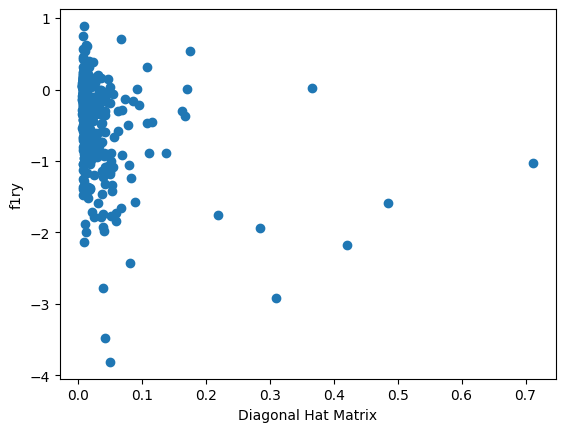

In [55]:
diag = np.diag(hat_matrix)
plt.scatter(diag, Y7)
plt.xlabel('Diagonal Hat Matrix')
plt.ylabel('f1ry')
plt.show()

We can see high leverage values of 0.2 to 0.7, meaning these points can potentially influence the regression model. Since most of the leverage observations are grouped between 0 and 0.02, observations outside this range can strongly impact the regression model.

### Studentized Residuals

The Studentized Residuals measures how good a fit for a model is, this can help us detect possible outliers in the regression model.

The get_influence() function from our model fit gives us this information.

In [56]:
diagnostics = mkmodel3.get_influence().summary_frame()
diagnostics

,dfb_const,dfb_w_pm,dfb_w_ato,dfb_w_epsp,dfb_w_oepsp,dfb_w_bmr,dfb_dmy_M,dfb_dmy_B,dfb_m*wepsp,dfb_b*wepsp,dfb_m*woepsp,dfb_b*woepsp,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
2,-0.01,0.09,0.00,-0.03,0.03,0.01,0.01,0.01,0.01,-0.00,-0.02,-0.01,0.00,-0.35,0.08,-0.11,-0.35,-0.11
8,0.00,0.01,-0.00,0.01,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.21,0.04,-0.04,-0.21,-0.04
16,-0.06,-0.03,0.05,-0.05,0.06,-0.04,0.06,0.05,0.01,0.01,-0.02,-0.01,0.00,-1.26,0.01,-0.13,-1.26,-0.13
17,0.30,-0.06,0.06,0.33,-0.02,-0.56,-0.15,-0.23,-0.07,-0.11,-0.01,0.03,0.09,-4.46,0.05,-1.03,-4.56,-1.05
30,0.01,-0.04,-0.02,0.03,0.02,0.01,-0.01,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,-0.60,0.04,-0.12,-0.59,-0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135,0.02,0.00,-0.01,0.00,-0.01,-0.02,-0.00,0.02,-0.00,0.01,0.00,-0.00,0.00,0.63,0.01,0.06,0.63,0.06
5154,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.00,-0.00,0.00,0.23,0.01,0.02,0.23,0.02
5156,0.01,0.00,-0.01,0.00,-0.00,-0.01,-0.00,0.02,-0.00,0.01,0.00,-0.01,0.00,0.36,0.01,0.03,0.36,0.03
5157,0.01,0.00,-0.01,0.00,-0.00,-0.00,-0.00,0.01,-0.00,0.00,0.00,-0.00,0.00,0.26,0.01,0.02,0.26,0.02


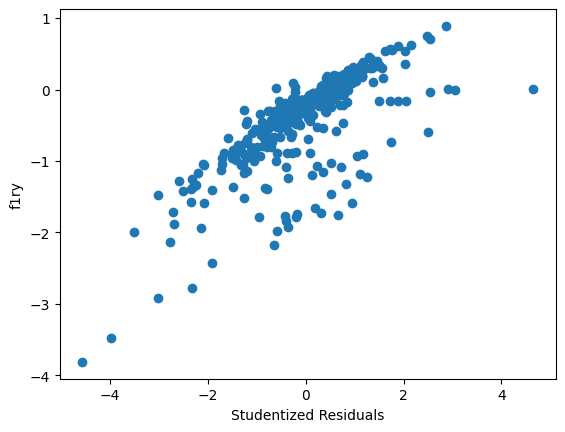

In [57]:
plt.scatter(diagnostics.student_resid, Y7)
plt.xlabel('Studentized Residuals')
plt.ylabel('f1ry')
plt.show()

Treshold to get values from -2 to 2, since most of the values are grouped here and the points that are outside this group can be considered possible outliers.

### Cook's distance

Cook's distance is helpful when trying to analyze whether there are outliers that could possibly affect the regression model, the greater the value for cook's distance, the higher the possibility of it affecting the model grows.

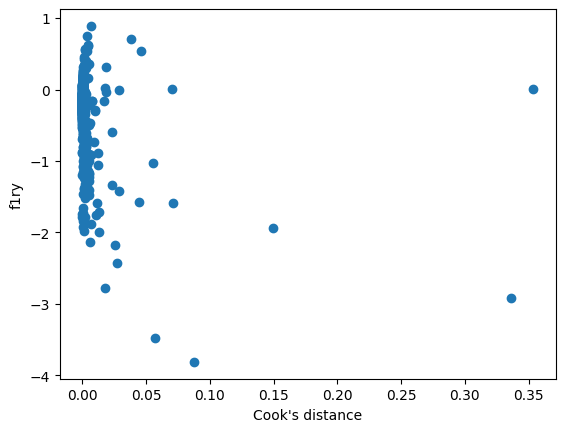

In [58]:
plt.scatter(diagnostics.cooks_d, Y7)
plt.xlabel("Cook's distance")
plt.ylabel('f1ry')
plt.show()

We can see from the graph, that a large group of cook's distance is found between values of zero to 0.10, and we can consider everything after this 0.10 value, a possible influential point or an outlier.

### Studentized Residuals and Cook's Distance to find possible influential observations

Since we know how Studentized Residuals and Cook's Distance work, we can use them both to analyze which observations could be considered outliers or influential points, which will affect the model performance.

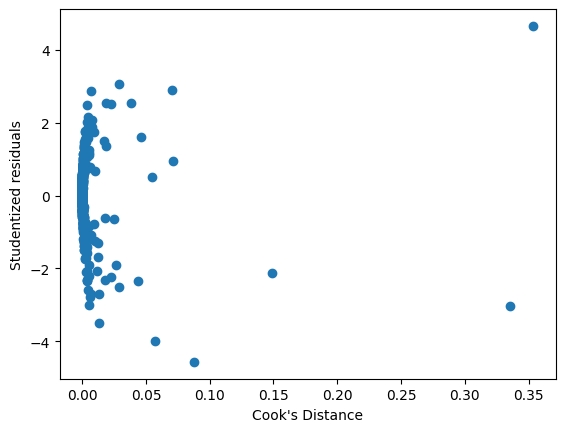

In [59]:
plt.scatter(x = diagnostics.cooks_d, y = diagnostics.student_resid)
plt.xlabel("Cook's Distance")
plt.ylabel('Studentized residuals')
plt.show()

We can observe the same thing as before, points greater than the absolute value of two for studentized residuals are considered outliers, and points greater than 0.10 in cook's distance are also considered outliers. This is taken into my consideration, since there's no absolute tresholds for neither of these variables.

Once identified these tresholds, we can analyze this diagnostics matrix and verify the tresholds we decided to use are helpful for the model.

In [60]:
outliers = np.where(np.abs(diagnostics.student_resid) > 2 | (diagnostics.cooks_d > 0.1))[0].tolist()
diagnostics = diagnostics.drop(diagnostics.index[outliers])

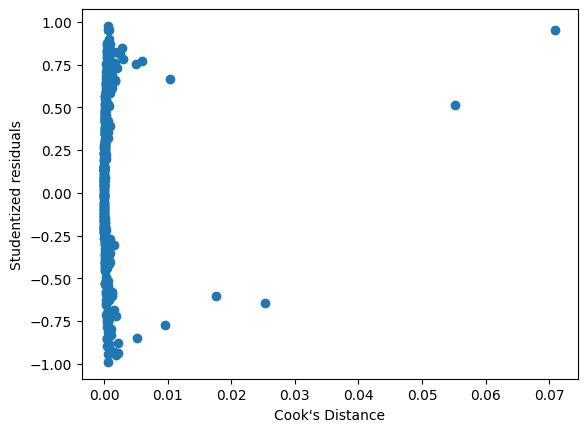

In [61]:
plt.scatter(x = diagnostics.cooks_d, y = diagnostics.student_resid)
plt.xlabel("Cook's Distance")
plt.ylabel('Studentized residuals')
plt.show()

Once there's no outliers to handle, we can re-run the regression model and compare these models.

In [62]:
X8 = services22[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr', 'dmy_M', 'dmy_B', 'f1ry']]
X8 = X8.drop(X8.index[outliers])
Y8 = X8[['f1ry']]
X8 = X8[['w_pm', 'w_ato', 'w_epsp', 'w_oepsp', 'w_bmr', 'dmy_M', 'dmy_B']]
X8 = sm.add_constant(X8)
X8

,const,w_pm,w_ato,w_epsp,w_oepsp,w_bmr,dmy_M,dmy_B
2,1.00,-9.39,0.01,-1.19,-1.16,1.26,0,0
8,1.00,-4.01,0.97,-1.80,-1.46,1.00,0,0
30,1.00,-1.13,1.46,-1.80,-1.46,0.71,0,0
38,1.00,-0.07,3.00,-1.80,-1.46,1.17,0,0
44,1.00,-0.21,2.21,-1.28,-1.39,1.66,0,0
...,...,...,...,...,...,...,...,...
5135,1.00,0.27,0.46,0.03,0.05,-0.03,0,1
5154,1.00,0.20,0.63,0.07,0.09,0.39,0,1
5156,1.00,0.45,0.57,0.03,0.04,0.02,0,1
5157,1.00,0.51,0.34,0.04,0.06,0.11,0,1


In [63]:
mkmodel4 = sm.OLS(Y8, X8, missing = 'drop').fit()

print(mkmodel4.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1ry   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     124.7
Date:                Mon, 02 Oct 2023   Prob (F-statistic):           5.76e-91
Time:                        20:32:28   Log-Likelihood:                 26.347
No. Observations:                 357   AIC:                            -36.69
Df Residuals:                     349   BIC:                            -5.673
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2114      0.036     -5.850      0.0

The quarterly stock returns, being the variable we want to analyze, is used to express the percentage change of an asset's value during a period of time. We can use this predictions to evaluate the performance of the assets during a time span, this by analyzing whether the quarterly returns are positive or negative to understand whether the revenue is growing or not. By analyzing this percent changes, we can understand the volatility of these returns and provide insights on the risk level when investing. In this case, the quarterly stock returns are going to be obtained a year in advance.

From the features selected to generate the Ordinary Least Squares Regression Model, only a few of them are significant, one of them is the winsorized value of the earnings per share deflated by stock, the winsorized values of the book market ratio. Since boh have a t value greater than two, the absolute value of the t value, meaning the coeffcient is significantly different to zero. When talking about the p value, we have a value lower than 0.05 for both coefficients, meaning we have more than 95% confidece to not make a mistake when rejecting the null hypothesis. The winsorized value of the earnings per share deflated by stock has a positive relation with the quarterly stock returns a year ahead, when the earnings per share deflated by stock grows in one unit, the dependent variable grows in 0.8822. The book to market ratio has a negative relation with the dependent variable, when the book to market ratio grows in one unit, the dependent variable decreases in 0.0888 units.

The winsorized value of the profit margin is marginally significant, since the t value is close to two, and it has a p value of 0.051, telling us there is ~95% of confidence of not making a mistake when rejecting the null hypothesis. There is a negative relation with the dependent variable, since with each unit the winsorized value of the profit margin grows, the quarterly stock returns a year ahead decreases in 0.0229 units. The winsorized value of the asset turn over ratio is also marginally significant, since it's t value is really close to two and the p value is lower than 0.05, giving us more than 95% confidence of not making a mistake when rejecting the null hypothesis.

The dummy variables for the size of the firms are dmy_M and dmy_B, which represents the average change of the quarterly stock returns a year ahead with reference to this change for the size Small of firms. Meaning for Medium firms, on average and compared to the Small size firms, the percentual change in quarterly stock returns is of -0.61%, while for Big firms, the percentual change is of 6.53%.

We observe a higher R^2 coefficient for this model, which is 0.714, meaning the accuracy is of 71.4%, it's way better than our first model, but there's also room for improvement. Even thought the accuracy is not ideal, we can have 71.4% confidence of making precise predictions.